<a href="https://colab.research.google.com/github/mcgmed/Tensorflow/blob/main/Introduction-to-Natural-Language-Processing/Using_Pretrained_Embeddings_from_TensorFlow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An alternative to training your own embeddings is to use ones that have been pretrained and packaged into Keras layers for you. There are many of these on Tensor‐Flow Hub that you can explore. One thing to note is that they can also contain the tokenization logic for you, so you don’t have to handle the tokenization, sequencing, and padding yourself as you have been doing so far.

In [1]:
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

training_size = 24000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

--2022-11-26 18:07:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.251.33.208, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2022-11-26 18:07:49 (104 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [2]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20], input_shape=[], dtype=tf.string, trainable=False)

This takes the embeddings from the Swivel dataset, trained on 130 GB of Google
News. Using this layer will encode your sentences, tokenize them, use the words from them with the embeddings learned as part of Swivel, and then encode your sentences into a single embedding. It’s worth remembering that final part. The technique we’ve been using to date is to just use the word encodings and classify the content based on all of them. When using a layer like this, you’re getting the full sentence aggregated into a new encoding.

In [3]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [4]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs, validation_data=(testing_sentences, testing_labels))

Epoch 1/50
750/750 [==============================] - 3s 2ms/step - loss: 0.6709 - accuracy: 0.5920 - val_loss: 0.6645 - val_accuracy: 0.6065
Epoch 2/50
750/750 [==============================] - 3s 3ms/step - loss: 0.6594 - accuracy: 0.6138 - val_loss: 0.6561 - val_accuracy: 0.6194
Epoch 3/50
750/750 [==============================] - 2s 3ms/step - loss: 0.6533 - accuracy: 0.6229 - val_loss: 0.6502 - val_accuracy: 0.6331
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 0.6490 - accuracy: 0.6300 - val_loss: 0.6469 - val_accuracy: 0.6342
Epoch 5/50
750/750 [==============================] - 2s 3ms/step - loss: 0.6455 - accuracy: 0.6363 - val_loss: 0.6446 - val_accuracy: 0.6316
Epoch 6/50
750/750 [==============================] - 2s 3ms/step - loss: 0.6426 - accuracy: 0.6389 - val_loss: 0.6421 - val_accuracy: 0.6327
Epoch 7/50
750/750 [==============================] - 1s 2ms/step - loss: 0.6401 - accuracy: 0.6421 - val_loss: 0.6397 - val_accuracy: 0.6346
Epoch 

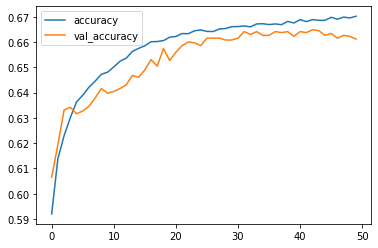

In [5]:
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.legend(['accuracy', 'val_accuracy']);

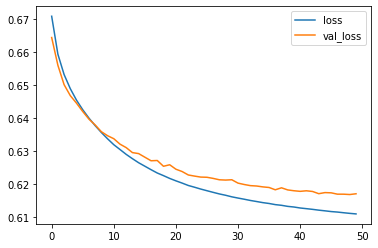

In [6]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.legend(['loss', 'val_loss']);

In [7]:
test_sentences = ["granny starting to fear spiders in the garden might be real",
                  "game of thrones season finale showing this sunday night",
                  "TensorFlow book will be a best seller"]

predictions = model.predict(test_sentences)
print(predictions)

1/1 [==============================] - 0s 106ms/step
[[0.5904082 ]
 [0.15055603]
 [0.4904335 ]]
